In [34]:
# --- Section 1: Setup ---
import os
import pandas as pd
import numpy as np
from PIL import Image
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    cohen_kappa_score, 
    log_loss, 
    classification_report, 
    confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Environment and Path Configuration
load_dotenv()
BASE_DIR = os.getenv('FILE_PATH')
if not BASE_DIR:
    raise ValueError("FILE_PATH environment variable not set. Please create a .env file and set it.")

DATA_PATH = os.path.join(BASE_DIR, 'Full_preprocessed_detailed_house.csv')
print(f"Base Directory: {BASE_DIR}")
print(f"Data CSV Path: {DATA_PATH}")

Using device: cuda
Base Directory: ../../../Samsung_USB/
Data CSV Path: ../../../Samsung_USB/Full_preprocessed_detailed_house.csv


In [35]:
# --- Section 2: Data Ingestion ---
df = pd.read_csv(DATA_PATH)

merge_map = {
    'Bovenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Benedenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Maisonnette': 'Bovenwoning/Benedenwoning/Maisonette',
    'Corridorflat': 'Corridorflat/Galerijflat',
    'Galerijflat': 'Corridorflat/Galerijflat',
    'Hoekwoning': 'Hoekwoning/Eindwoning',
    'Eindwoning': 'Hoekwoning/Eindwoning',
    'Portiekflat': 'Portiekflat/Portiekwoning',
    'Portiekwoning': 'Portiekflat/Portiekwoning'

    # etc.
}

df['woningtype'] = df['woningtype'].map(merge_map).fillna(df['woningtype'])


print("Successfully loaded data. Shape:", df.shape)

Successfully loaded data. Shape: (6595, 23)


In [36]:
# --- Section 3: Preprocessing and Splitting ---

def preprocess_tabular_data(train_df, val_df, test_df):
    """Scales numeric columns and one-hot encodes categorical columns."""
    numeric_cols = ['opp_pand', 'build_year']
    categorical_cols = ['build_type']
    
    # Scale numeric columns based on the training set
    scaler = StandardScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
    print("Numeric features scaled.")

    # One-hot encode categorical columns based on the training set
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(train_df[categorical_cols])
    
    cat_encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

    def encode_and_merge(df, encoder):
        encoded_data = encoder.transform(df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_data, columns=cat_encoded_cols, index=df.index)
        return pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

    train_df = encode_and_merge(train_df, encoder)
    val_df = encode_and_merge(val_df, encoder)
    test_df = encode_and_merge(test_df, encoder)
    print("Categorical features one-hot encoded.")
    
    return train_df, val_df, test_df, numeric_cols, cat_encoded_cols


def clean_and_convert_features(df, feature_list):
    """Ensures all specified feature columns are numeric, filling NaNs."""
    cleaned_df = df.copy()
    for feature in feature_list:
        if feature in cleaned_df.columns:
            # Convert to numeric, coercing errors to NaN
            cleaned_df[feature] = pd.to_numeric(cleaned_df[feature], errors='coerce')
            # Fill any resulting NaNs with 0 (or a more suitable value like the mean)
            if cleaned_df[feature].isnull().sum() > 0:
                cleaned_df[feature] = cleaned_df[feature].fillna(0)
            # Ensure final type is float32 for PyTorch
            cleaned_df[feature] = cleaned_df[feature].astype('float32')
    return cleaned_df

def prepare_final_data(df, base_path):
    """Adds the full image path and encodes the 'woningtype' label."""
    # Build full image path
    df['img_path'] = df['frontview_url'].apply(lambda x: os.path.join(base_path, x))
    return df

# 1. Split the original dataframe
print("Splitting data into train (60%), validation (20%), and test (20%)...")
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['woningtype'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['woningtype'])

# 2. Preprocess tabular data (scaling and encoding)
train_df, val_df, test_df, numeric_cols, cat_encoded_cols = preprocess_tabular_data(train_df, val_df, test_df)

# 3. Define the full list of features for the model
tabular_features = numeric_cols + cat_encoded_cols
print(f"Total tabular features ({len(tabular_features)}): {tabular_features}")

# 4. Clean the dataframes to ensure all feature columns are numeric
print("Cleaning and converting features to numeric types...")
train_df = clean_and_convert_features(train_df, tabular_features)
val_df = clean_and_convert_features(val_df, tabular_features)
test_df = clean_and_convert_features(test_df, tabular_features)

# 5. Create image paths and encode labels
print("Preparing final data (image paths and labels)...")
train_df = prepare_final_data(train_df, BASE_DIR)
val_df = prepare_final_data(val_df, BASE_DIR)
test_df = prepare_final_data(test_df, BASE_DIR)

# Fit LabelEncoder on the full training 'woningtype' to create integer labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['woningtype'])
# Use the same encoder for validation and test sets
val_df['label'] = label_encoder.transform(val_df['woningtype'])
test_df['label'] = label_encoder.transform(test_df['woningtype'])

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

image_list = []

Splitting data into train (60%), validation (20%), and test (20%)...
Numeric features scaled.
Categorical features one-hot encoded.
Total tabular features (7): ['opp_pand', 'build_year', 'build_type_Appartement', 'build_type_Hoekwoning', 'build_type_Tussen of geschakelde woning', 'build_type_Tweeonder1kap', 'build_type_Vrijstaande woning']
Cleaning and converting features to numeric types...
Preparing final data (image paths and labels)...
Train size: 3957 | Val size: 1319 | Test size: 1319
Number of classes: 10


1250 images processed. Stopping for review.


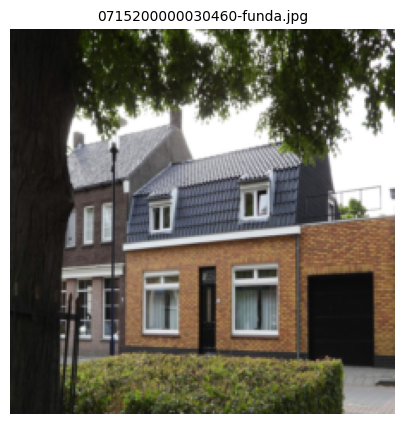

Image path: ../../../Samsung_USB/img_dataset/07/0715200000030460-funda.jpg
1251 images processed. Stopping for review.


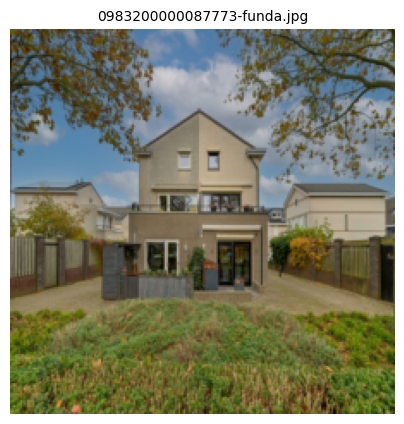

Image path: ../../../Samsung_USB/img_dataset/09/0983200000087773-funda.jpg
1252 images processed. Stopping for review.


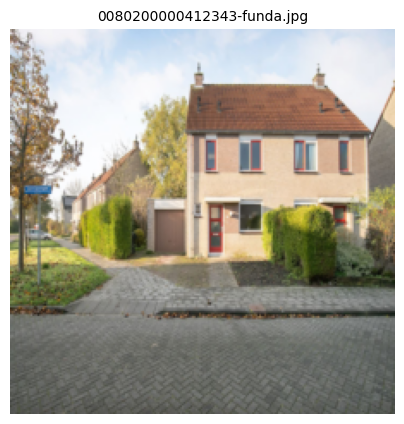

Image path: ../../../Samsung_USB/img_dataset/00/0080200000412343-funda.jpg
1253 images processed. Stopping for review.


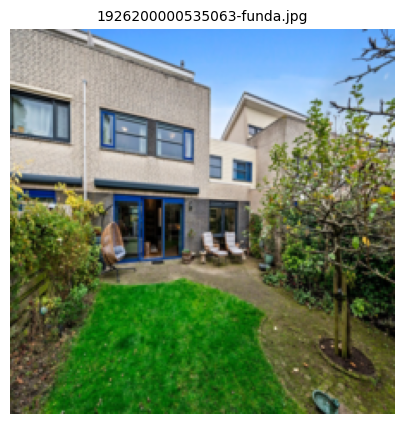

Image path: ../../../Samsung_USB/img_dataset/19/1926200000535063-funda.jpg
1254 images processed. Stopping for review.


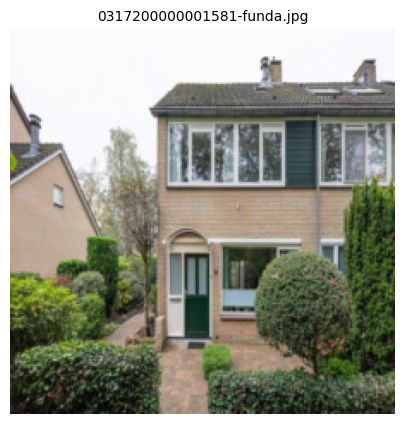

Image path: ../../../Samsung_USB/img_dataset/03/0317200000001581-funda.jpg
1255 images processed. Stopping for review.


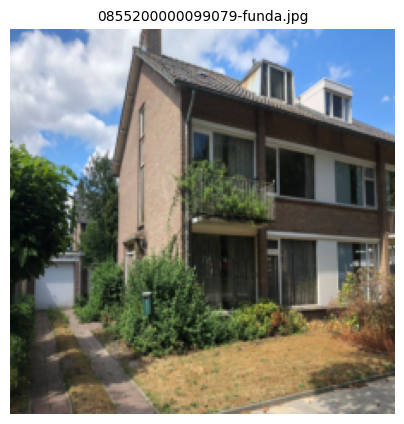

Image path: ../../../Samsung_USB/img_dataset/08/0855200000099079-funda.jpg
1256 images processed. Stopping for review.


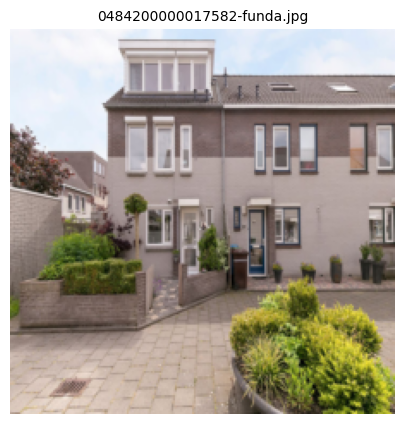

Image path: ../../../Samsung_USB/img_dataset/04/0484200000017582-funda.jpg
1257 images processed. Stopping for review.


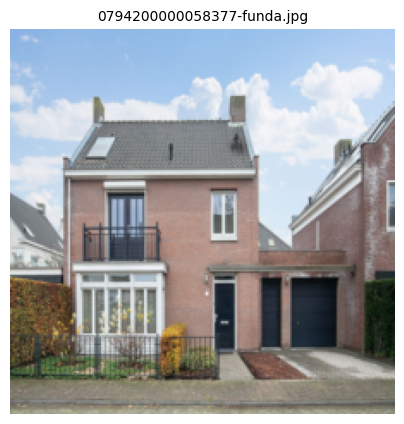

Image path: ../../../Samsung_USB/img_dataset/07/0794200000058377-funda.jpg
1258 images processed. Stopping for review.


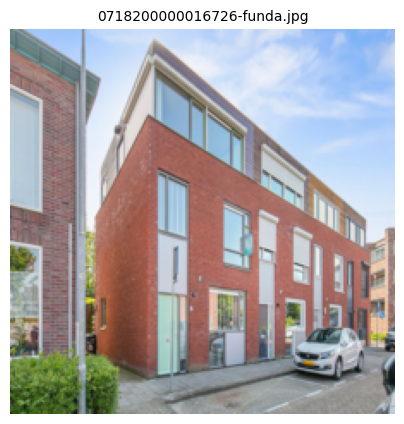

Image path: ../../../Samsung_USB/img_dataset/07/0718200000016726-funda.jpg
1259 images processed. Stopping for review.


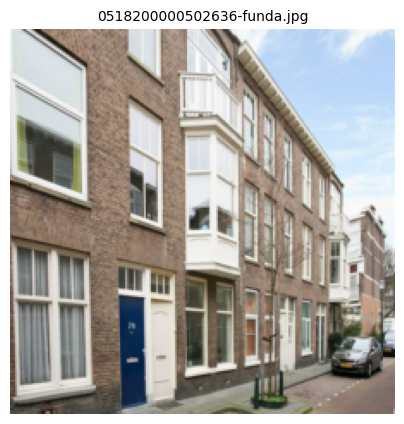

Image path: ../../../Samsung_USB/img_dataset/05/0518200000502636-funda.jpg
1260 images processed. Stopping for review.


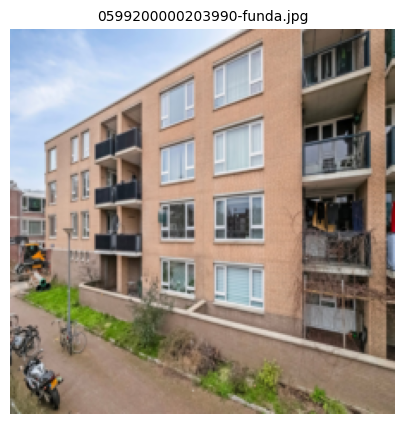

Image path: ../../../Samsung_USB/img_dataset/05/0599200000203990-funda.jpg
1261 images processed. Stopping for review.


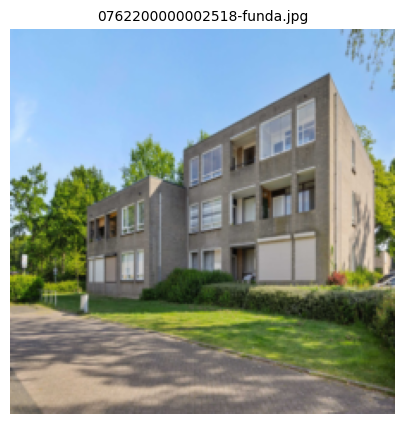

Image path: ../../../Samsung_USB/img_dataset/07/0762200000002518-funda.jpg
1262 images processed. Stopping for review.


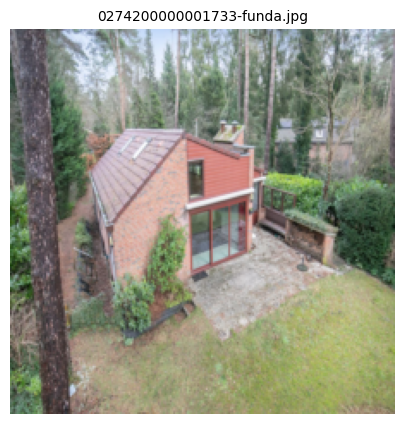

Image path: ../../../Samsung_USB/img_dataset/02/0274200000001733-funda.jpg
1263 images processed. Stopping for review.


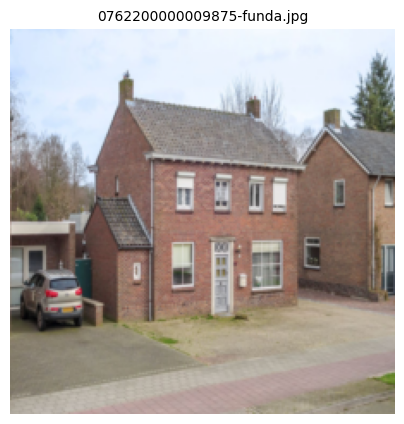

Image path: ../../../Samsung_USB/img_dataset/07/0762200000009875-funda.jpg
1264 images processed. Stopping for review.


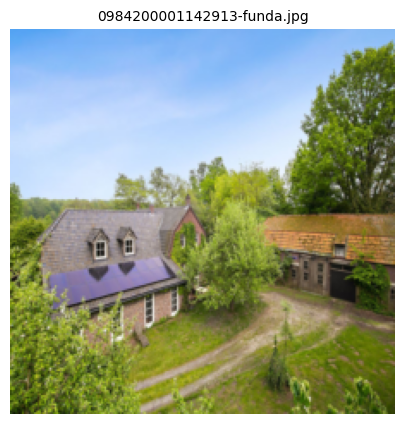

Image path: ../../../Samsung_USB/img_dataset/09/0984200001142913-funda.jpg
1265 images processed. Stopping for review.


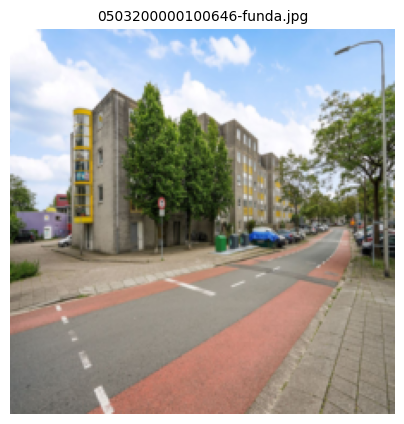

Image path: ../../../Samsung_USB/img_dataset/05/0503200000100646-funda.jpg
1266 images processed. Stopping for review.


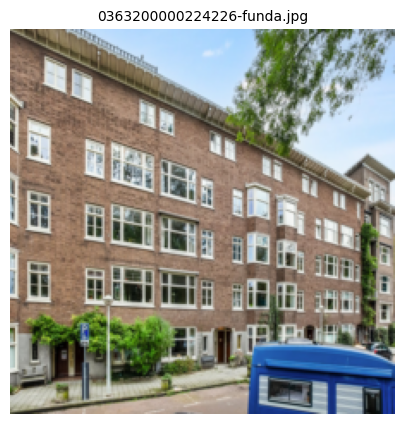

Image path: ../../../Samsung_USB/img_dataset/03/0363200000224226-funda.jpg
1267 images processed. Stopping for review.


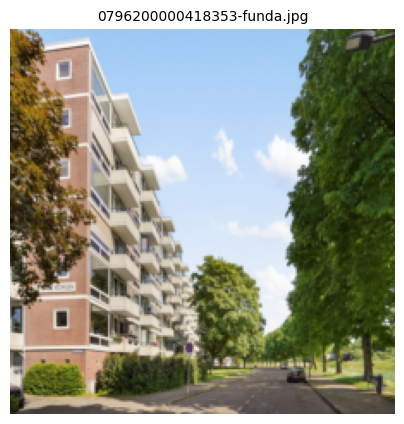

Image path: ../../../Samsung_USB/img_dataset/07/0796200000418353-funda.jpg
1268 images processed. Stopping for review.


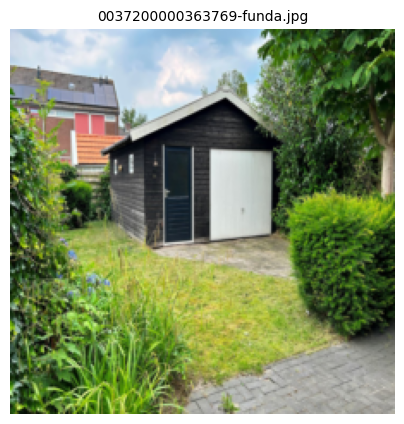

Image path: ../../../Samsung_USB/img_dataset/00/0037200000363769-funda.jpg
1269 images processed. Stopping for review.


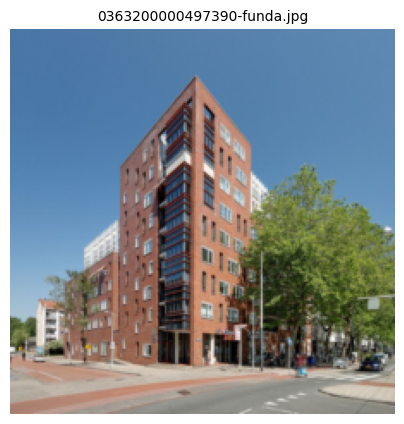

Image path: ../../../Samsung_USB/img_dataset/03/0363200000497390-funda.jpg
Selected images for review:  ['../../../Samsung_USB/img_dataset/05/0503200000100646-funda.jpg']


In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

# --- Dataset Definition ---

class HousingDataset(Dataset):
    def __init__(self, df, tabular_features, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.tabular_features = tabular_features
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img = Image.open(row['img_path']).convert('RGB')
            if self.transform:
                img = self.transform(img)
            v = row[self.tabular_features].values.astype(np.float32)
            tab_feats = torch.from_numpy(v)
            label = torch.tensor(row['label'], dtype=torch.long)
            return img, tab_feats, label
        except:
            return self.__getitem__((idx + 1) % len(self))


# --- Extended Dataset for Filtering ---
class HousingDatasetWithPath(HousingDataset):
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img_path = row['img_path']
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            v = row[self.tabular_features].values.astype(np.float32)
            tab_feats = torch.from_numpy(v)
            label = torch.tensor(row['label'], dtype=torch.long)
            return img, tab_feats, label, img_path
        except:
            return self.__getitem__((idx + 1) % len(self))

# --- Transforms ---

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# --- Dataset and Splits ---

# Use the dataset with paths
base_dataset = HousingDatasetWithPath(train_df, tabular_features, transform=val_transforms)

# Shuffle indices and split into 3 parts
total_size = len(base_dataset)
split_size = total_size // 3
remainder = total_size % 3

indices = list(range(total_size))
np.random.seed(42)  # Make the splits reproducible
np.random.shuffle(indices)

split1_indices = indices[:split_size]
split2_indices = indices[split_size:2*split_size]
split3_indices = indices[2*split_size:] + indices[3*split_size:]

# Create subsets
split1 = Subset(base_dataset, split1_indices)
split2 = Subset(base_dataset, split2_indices)
split3 = Subset(base_dataset, split3_indices)

# --- DataLoaders for 3 people ---
loader1 = DataLoader(split1, batch_size=1, shuffle=False, num_workers=0)
loader2 = DataLoader(split2, batch_size=1, shuffle=False, num_workers=0)
loader3 = DataLoader(split3, batch_size=1, shuffle=False, num_workers=0)

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)

chosen_loader = loader3  # Change to loader1 or loader2 for other splits

for idx, batch in enumerate(chosen_loader):
    if idx >= 1250:
        print(idx, "images processed. Stopping for review.")
        imgs, _, _, paths = batch
        img = denormalize(imgs[0])
        plt.figure(figsize=(5, 5))
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(os.path.basename(paths[0]), fontsize=10)
        plt.axis('off')
        plt.show()
        print(f"Image path: {paths[0]}")
        user_input = input("Add this image to the list? (k to add, or 'q' to quit): ")
        if user_input.lower() == 'k':
            image_list.append(paths[0])
        elif user_input.lower() == 'q':
            break
    else:
        continue

print("Selected images for review: ", image_list)


In [38]:
ToBeFiltered = ['img_dataset/03/0344200000173950-funda.jpg',
                'img_dataset/05/0518200000560249-funda.jpg',
                'img_dataset/03/0327200000267290-funda.jpg',
                'img_dataset/09/0935200000054573-google.jpg',
                'img_dataset/00/0055200000279289-funda.jpg',
                'img_dataset/00/0080200000463819-funda.jpg',
                'img_dataset/02/0202200000431889-funda.jpg',
                'img_dataset/05/0599200000786636-funda.jpg',
                'img_dataset/03/0301200000000312-funda.jpg',
                'img_dataset/03/0392200000010646-funda.jpg',
                'img_dataset/16/1669200000223992-funda.jpg',
                'img_dataset/04/0405200001009440-funda.jpg',
                'img_dataset/04/0402200001534400-funda.jpg',
                'img_dataset/05/0513200000002660-google.jpg',
                'img_dataset/03/0345200002025714-funda.jpg',
                'img_dataset/04/0479200000020272-funda.jpg',
                'img_dataset/04/0406200000069445-funda.jpg',
                'img_dataset/09/0983200000005944-funda.jpg',
                'img_dataset/05/0599200000192439-funda.jpg',
                'img_dataset/18/1895200000018624-funda.jpg',
                'img_dataset/03/0392200000007383-funda.jpg',
                
            ]

print(image_list)
print(len(image_list))

for img_path in image_list:
    pass
    image_list = [img_path.replace('../../../Samsung_USB/', '') for img_path in image_list]

ToBeFiltered = ToBeFiltered + image_list
ToBeFiltered = list(set(ToBeFiltered))  # Remove duplicates

print("Final list of images to be filtered:", ToBeFiltered)

['../../../Samsung_USB/img_dataset/05/0503200000100646-funda.jpg']
1
Final list of images to be filtered: ['img_dataset/00/0080200000463819-funda.jpg', 'img_dataset/09/0935200000054573-google.jpg', 'img_dataset/03/0344200000173950-funda.jpg', 'img_dataset/05/0503200000100646-funda.jpg', 'img_dataset/02/0202200000431889-funda.jpg', 'img_dataset/04/0479200000020272-funda.jpg', 'img_dataset/03/0327200000267290-funda.jpg', 'img_dataset/03/0392200000010646-funda.jpg', 'img_dataset/05/0599200000192439-funda.jpg', 'img_dataset/04/0405200001009440-funda.jpg', 'img_dataset/18/1895200000018624-funda.jpg', 'img_dataset/03/0345200002025714-funda.jpg', 'img_dataset/05/0518200000560249-funda.jpg', 'img_dataset/04/0402200001534400-funda.jpg', 'img_dataset/03/0301200000000312-funda.jpg', 'img_dataset/16/1669200000223992-funda.jpg', 'img_dataset/00/0055200000279289-funda.jpg', 'img_dataset/05/0599200000786636-funda.jpg', 'img_dataset/05/0513200000002660-google.jpg', 'img_dataset/03/0392200000007383-fun